In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *
import time
#mean squared error: 0.00302
#params=np.array([\
# 1.00019169, 1.00485457, 0.98089897,\
# 0.00173489, 0.03556878, 0.19213672,\
# 0.99867178, 0.00847006, 0.02213006, 0.12979466]

#msqerr: 0.0029
#[ 1.0003588   1.00501068  0.98071385  0.00298074  0.0019567   0.20618256
#  1.03816403 -0.02316948 -0.01194352  0.12074971]

#msqerr: 0.0016
#[ 1.00019457  1.00488652  0.98081785  0.00157861  0.03279509  0.19761574
#  0.99666972  0.00134338  0.0370082  -0.02798724]

In [3]:
#Read in the raw data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the magnetometer data in numpy form
dfMag=raw_dat['mag']
mag=dfMag.to_numpy()
# Get the magnetometer time series in seconds
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]

# Synch the gyro to the magnetometer, convert to radians/s
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()

#Sync the accelerometer to the gyro
#the 8g accelerometer is by far the best.
acc=   synchronize_series(raw_dat['acc8'],ref=dfMag).to_numpy()


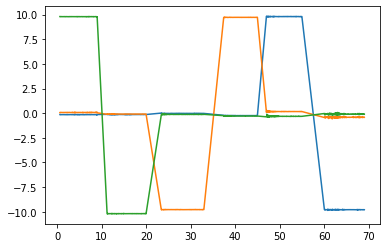

In [31]:
## Find the intervals where the sensor is stationary
intervals=[\
          (0.6,9),\
          (11.2,20),\
          (23.4,33),\
          (37.4,45),\
          (47,55),\
          (60,69),\
          ]       


ts_0,acc_0=idx_filter(ts,acc,intervals)
plt.plot(ts_0,acc_0)

In [86]:
#params=[scale0,scale1,scale2,bias1,bias2,bias3,qw,qx,qy,qz]

#Initial guess
params=np.array([\
    1.0,1.0,1.0,\
    0.0,0.0,0.0,\
    1.0,0.0,0.0,0.0 \
    ])


#Use the last best guess
#params=[ 1.00019457,  1.00488652,  0.98081785,  \
#        0.00157861,  0.03279509,   0.19761574,  \
#        0.99666972,  0.00134338,  0.0370082 , -0.02798724]

print(msqError(params,intervals,acc,gyro,mag,ts))

##Allocate arrays once for speedup
#workspace={}
#num_samples=len(ts)
#workspace['acc_scratch']=np.zeros((num_samples,3))
#workspace['Q']=np.tile(np.array([1.0,0.0,0.0,0.0]),(num_samples,1))
#workspace['Q_quat']=np.tile(Quaternion(np.array([1.0,0.0,0.0,0.0])),(num_samples,1))
#workspace['acc_lab']=np.zeros((num_samples,3))
#func = lambda params: msqError(params,intervals,acc,gyro,mag,ts,workspace=workspace)


##Takes 223 seconds to compute with preallocation
## 209 seconds without preallocation
func = lambda params: msqError(params,intervals,acc,gyro,mag,ts)

tic=time.time()
sol=minimize(func,params)
toc=time.time()

print(f"Minimization took {toc-tic:0.1f} seconds")
print(sol)

0.029181365688571645
Minimization took 209.2 seconds
      fun: 0.0016264259775881059
 hess_inv: array([[ 1.35994040e-02, -2.26734545e-04, -1.08833267e-03,
         1.68390204e-03, -1.10418176e-02,  2.19169513e-03,
        -1.45648380e-02, -2.82514315e-03, -7.99862368e-04,
         5.38841335e-03],
       [-2.26734545e-04,  1.23259995e-02, -5.46221514e-04,
         1.85012057e-03,  4.59615924e-03, -8.31039669e-03,
         1.10805289e-02,  1.78758693e-03,  5.28153659e-04,
        -4.08360270e-03],
       [-1.08833267e-03, -5.46221514e-04,  9.32702808e-03,
        -7.52737920e-03,  8.69313413e-03,  5.70562528e-03,
        -2.20894645e-03,  1.55426265e-03,  4.58848032e-04,
        -6.89403788e-03],
       [ 1.68390204e-03,  1.85012057e-03, -7.52737920e-03,
         4.48287985e-01, -1.99617289e-01,  5.40817028e-02,
        -1.02140992e-01,  2.55103041e-03, -2.46728971e-02,
         4.87800432e-02],
       [-1.10418176e-02,  4.59615924e-03,  8.69313413e-03,
        -1.99617289e-01,  2.9603

(0.9989 +0.0013i +0.0371j -0.0281k)


Text(0, 0.5, 'lab frame acceleration (m/s^2)')

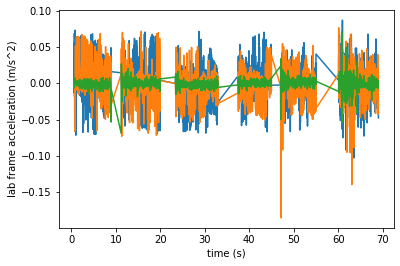

In [88]:

params=sol.x
q=np.array(params[6:])
q/=np.linalg.norm(q)
q0=Quaternion(q)
print(q0)

## Apply scale-bias calibration
acc_calibrated=calibrate(acc,params=params)

# Rotate into lab frame using initial orientation
for i in range(len(acc_calibrated)):
    acc_calibrated[i]=q0.rotate(acc_calibrated[i])

#plt.plot(ts,acc_calibrated)

# Use madgwick filter to estimate orientation, and integrate to find position estimate
ACC_LAB,QIMU,state=apply_ahrs(gyro,acc_calibrated,mag,ts,q0=q,g=[0,0,9.799],position=True)

#Plot the quiet parts of the calibration data
ts_0,ACC_LAB0=idx_filter(ts,ACC_LAB,intervals)
plt.plot(ts_0,ACC_LAB0)
plt.xlabel("time (s)")
plt.ylabel("lab frame acceleration (m/s^2)")

[(0.6, 9), (11.2, 20), (23.4, 33), (37.4, 45), (47, 55), (60, 69)]


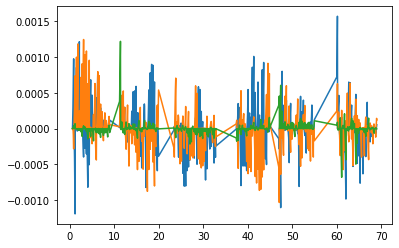

In [76]:
## Inspect the dead-reckoning position estimate
print(intervals)
ts_masked,state_masked=idx_filter(ts,state,intervals)
plt.plot(ts_masked,state_masked[:,0])
plt.plot(ts_masked,state_masked[:,1])
plt.plot(ts_masked,state_masked[:,2])

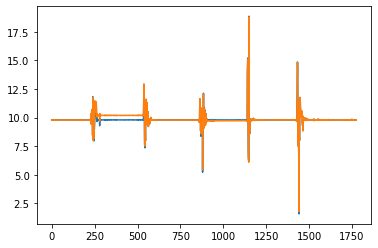

In [63]:
#Compare the uncalibrated vs calibrated acceleration magnitudes
plt.plot(np.sum(apply_calibration(acc)**2,axis=1)**0.5  )
plt.plot(np.sum(acc**2,axis=1  )**0.5)